### Copyright 2022 Edward Späth, Frankfurt University of Applied Sciences, FB2, Computer Science
### No liability or warranty; only for educational and non-commercial purposes
### See some basic hints for working with Jupyter notebooks in README.md

## Breadth-First Search (BFS) and Depth-First Search (DFS) with visualization

## Data structure for storing node info

In [1]:
class Node:
    node_id = 0
    def __init__(self, name_input):
        self.name = name_input
        self.predecessor = 'NIL'
        self.distance = '∞'
        self.adjacencylist = []
        self.weightlist = []
        my_dict[self.name] = Node.node_id
        Node.node_id += 1
        # For DFS
        self.t_discovered = 'NIL'
        self.t_finished = 'NIL'

## Global variables for storing information

In [2]:
WEIGHTED_GRAPH = True # All booleans can be changed below. Please do not change them here!
DIRECTED_GRAPH = True
GRAPHS_PER_LINE = 2
BFS_DISPLAY_STEP_BY_STEP = False
my_dict = {} # for easier access, each node's name returns said node's index in the list if hashed. 
             # nodes is the only list which stores objects. All the other lists only store names, which can then be hashed to access the actual object
nodes = []
discovered_nodes = [] # Referred to as 'Gray' Nodes in FRA-UAS AlgDat lecture materials (Discovered)
visited_nodes = []    # Referred to as 'Black' Nodes...
                      # Referred to as 'White' Nodes... (being in neither one of those lists)
currently_visiting = [] # For highlighting the currently visited node
current_step = 0
invisible_graph_index = -1 # For creating empty graphs (formatting). Index starts at -1 and is decremented. Only used to uniquely name the nodes
visited_nodes_steps, discovered_nodes_steps = [], []

In [3]:
def reset_results(): # Resets data after results were printed
    global discovered_nodes, visited_nodes, currently_visiting, current_step, invisible_graph_index, visited_nodes_steps, discovered_nodes_steps, time
    discovered_nodes, visited_nodes = [], []
    currently_visiting = []
    current_step = 0
    invisible_graph_index = -1
    visited_nodes_steps, discovered_nodes_steps = [], []
    time = 0 # For DFS
    # Set node statistics back to initial values.
    for node in nodes:  
        node.predecessor = 'NIL'
        node.distance = '∞'
        node.t_discovered = 'NIL'
        node.t_finished = 'NIL'

In [4]:
def reset_graph():
    global nodes, my_dict
    nodes = []
    my_dict = {}
    Node.node_id = 0

## Output colors

In [5]:
# Node color in output. Defaults are 'white', 'lightgray', 'slategray', 'black'
COL_NODE_UNDISCOVERED = 'white'
COL_NODE_DISCOVERED = 'lightgray'
COL_NODE_CURRENTLY_VISITING = 'slategray' # Will highlight the last discovered node in DFS and the node currently visiting in BFS (if BFS_DISPLAY_STEP_BY_STEP = True)
COL_NODE_VISITED = 'black'
# Color for node font (black text on black background is not a good idea afterall). Defaults are 'black', 'black', 'black', 'white'
COL_FC_NODE_UNDISCOVERED = 'black'
COL_FC_NODE_DISCOVERED = 'black'
COL_FC_NODE_CURRENTLY_VISITING = 'black'
COL_FC_NODE_VISITED = 'white'

## Visualization

In [6]:
from graphviz import Digraph
from graphviz import Graph
def draw_graphs(traversal_type):
    global current_step # Step index
    while current_step < len(visited_nodes_steps):
        steps_taken = 0 # For label output "(Steps x - y)"
        if DIRECTED_GRAPH:
            dot = Digraph()
        else:
            dot = Graph(strict=True) # strict prevents multiple edges between two nodes, which are unnecessary in an undirected Graph
        for _ in range(GRAPHS_PER_LINE):
            if current_step >= len(visited_nodes_steps):
                break
            create_subgraph(dot)
            steps_taken += 1
        if steps_taken < GRAPHS_PER_LINE:
            for _ in range(GRAPHS_PER_LINE-steps_taken):
                create_subgraph(dot, invisible_graph=True)
        if current_step-steps_taken+1 == 1: # Only True for the first row of output. I want the name of the algorithm (BFS/DFS) to only be printed on the first image
            displayed_algorithm_name = traversal_type + ' '
        else:
            displayed_algorithm_name = '' # Leaving out the algorithm name
        
        if steps_taken == 1:
            label_input = displayed_algorithm_name + 'Step ' + str(current_step)
        else:
            label_input = displayed_algorithm_name + 'Steps ' + str(current_step-steps_taken+1) + ' - ' + str(current_step)
        dot.attr(labelloc='t', label=label_input)
        display(dot)

In [7]:
def create_subgraph(dot, invisible_graph=False):
    global current_step, invisible_graph_index
    # sub represents each subgraph for a given dot object. They have to be named in the form 'cluster_x' with x being an integer
    with dot.subgraph(name='cluster_' + str(current_step)) as sub:
        # Adding the nodes
        for node in nodes:
            if invisible_graph:
                _ = 5 # Do nothing
            elif node.name == currently_visiting[current_step]:
                corresponding_bg_color = COL_NODE_CURRENTLY_VISITING
                corresponding_font_color = COL_FC_NODE_CURRENTLY_VISITING
            elif node.name not in discovered_nodes_steps[current_step] and node.name not in visited_nodes_steps[current_step]: # case 'White'
                corresponding_bg_color = COL_NODE_UNDISCOVERED
                corresponding_font_color = COL_FC_NODE_UNDISCOVERED
            elif node.name not in visited_nodes_steps[current_step]: # case 'Gray'
                corresponding_bg_color = COL_NODE_DISCOVERED
                corresponding_font_color = COL_FC_NODE_DISCOVERED
            else: # case 'Black'
                corresponding_bg_color = COL_NODE_VISITED
                corresponding_font_color = COL_FC_NODE_VISITED
            if invisible_graph:
                sub.attr('node', style='invis')
            else:
                sub.attr('node', style='filled', fillcolor=corresponding_bg_color, fontcolor=corresponding_font_color)
            if invisible_graph:
                sub.node(str(invisible_graph_index)+str(node.name), node.name)
            else: 
                sub.node(str(current_step)+str(node.name), node.name)
        # Adding the edges
        for node in nodes:
            for weight_index, adjacent_name in enumerate(node.adjacencylist):
                if WEIGHTED_GRAPH: # If it's an unweighted graph, the label can be left out entirely
                    if invisible_graph:
                        sub.attr('edge', style='invis')
                    else:
                        sub.attr('edge', label=str(node.weightlist[weight_index]))
                if invisible_graph:
                    sub.edge(str(invisible_graph_index)+str(node.name), str(invisible_graph_index)+str(adjacent_name)) 
                else:
                    sub.edge(str(current_step)+str(node.name), str(current_step)+str(adjacent_name)) 
        if not invisible_graph:
            current_step += 1
        else:
            invisible_graph_index -= 1
        if invisible_graph:
            sub.attr(labelloc='b', label='', color='transparent')
        else:
            sub.attr(labelloc='b', label='(' + str(current_step) + ')', color='transparent') # color='transparent' gets rid of those boxes around each subgraph

In [8]:
import copy
def save_graph():
    global visited_nodes_steps, discovered_nodes_steps
    # A deep copy is needed as the data is not supposed to be changed.
    # Not using a deep copy would result in all previous states being overwritten by the last one
    visited_nodes_steps.append(copy.deepcopy(visited_nodes))
    discovered_nodes_steps.append(copy.deepcopy(discovered_nodes))

## Constants for visualizing the chart

In [9]:
X_FIGSIZE_SCALING_FACTOR = 1.5
X_MIN_FIGSIZE = 11
BOTTOM_TEXT_Y_CORD = 0.25 # y coordinate of the bottom text row
X_INFO_START = 1 # x coordinate where the first column of information starts (excluding column with labels such as name, predecessor, etc.)
Y_OFFSET_VLINE_HEIGHT = 0.15 # How many coordinate units the vertical lines are allowed to be higher/lower than the top/bottom text row
OFFSET = 0.5
COL_LINES = 'k'
REGULAR_LINE_WIDTH = 2
TOP_H_LINE_WIDTH = 4

## Visualizing the chart with the results

In [10]:
import matplotlib.pyplot as plt
def show_result_chart(start_nodes, traversal_type):
    x_figsize =len(nodes)*X_FIGSIZE_SCALING_FACTOR # Scaling figure size with number of nodes
    if x_figsize < X_MIN_FIGSIZE:
        x_figsize = X_MIN_FIGSIZE
    plt.figure(figsize=(x_figsize, 6))
    if traversal_type == 'DFS':
        # Rows of information means distance, predecessor, etc.
        amt_information_rows = 5
    else:
        amt_information_rows = 3
    amt_h_lines = amt_information_rows-1
    y_end = amt_information_rows*OFFSET # The coordinate where the y axis ends
    x_end = (len(nodes)+1)*OFFSET+OFFSET/2 # The coordinate where the x axis ends
    plt.axis([0, x_end, 0, y_end]) # x_start, x_end, y_start, y_end
    plt.axis('off')
    # Plotting the regular hlines
    for j in range(0, amt_h_lines-1):
        plt.hlines(xmin=0, xmax=x_end, y=BOTTOM_TEXT_Y_CORD+OFFSET/2 + j*OFFSET, color=COL_LINES, linewidth=REGULAR_LINE_WIDTH)
    # Plotting the hline at the top 
    plt.hlines(xmin=-5, xmax=x_end, y=BOTTOM_TEXT_Y_CORD+OFFSET/2 + (amt_h_lines-1)*OFFSET, color=COL_LINES, linewidth=TOP_H_LINE_WIDTH)
    info_y_cords = []
    information_labels = ['Name', 'Distance', 'Predecessor', 'Step where\n discovered', 'Step where\n finished']
    for j in range(0, amt_information_rows):
        info_y_cords.append(BOTTOM_TEXT_Y_CORD + j*OFFSET)
        plt.text(x=0, y=BOTTOM_TEXT_Y_CORD + j*OFFSET, s=information_labels[amt_information_rows-j-1], fontsize=16, verticalalignment='center', horizontalalignment='left')
    for node_index, node in enumerate(nodes):
        if not isinstance(node.distance, str): # Only False when distance is infinity. I want to increase infinity symbol size without increasing the numbers' font-size
            distance_fontsize = 16
        else:
            distance_fontsize = 25
        x_cord = X_INFO_START + node_index*OFFSET
        plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-1)*OFFSET, s=str(node.name), fontsize=16, verticalalignment='center', horizontalalignment='center')
        plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-2)*OFFSET, s=str(node.distance), fontsize=distance_fontsize, verticalalignment='center', horizontalalignment='center')
        plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-3)*OFFSET, s=str(node.predecessor), fontsize=16, verticalalignment='center', horizontalalignment='center')
        if traversal_type == 'DFS':
            plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-4)*OFFSET, s=str(node.t_discovered), fontsize=16, verticalalignment='center', horizontalalignment='center')
            plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-5)*OFFSET, s=str(node.t_finished), fontsize=16, verticalalignment='center', horizontalalignment='center')
    for vline_index, _ in enumerate(nodes):
        plt.vlines(x=X_INFO_START-OFFSET/2 + vline_index*OFFSET, ymin=BOTTOM_TEXT_Y_CORD-Y_OFFSET_VLINE_HEIGHT, 
                   ymax=BOTTOM_TEXT_Y_CORD + (amt_information_rows-1)*OFFSET + Y_OFFSET_VLINE_HEIGHT, color=COL_LINES, linewidth=REGULAR_LINE_WIDTH)
    if len(start_nodes) == 1:
        start_text =  '(Starting node: ' + start_nodes[0] + ')'
    else:
        start_text =  '(Starting nodes: '
        for index, start_node in enumerate(start_nodes):
            start_text += str(start_node)
            if index != len(start_nodes)-1:
                start_text += ', '
        start_text += ')'
    plt.title(traversal_type + ' result ' + start_text, fontsize=20)
    plt.show()

## Functions for adding nodes and edges

In [11]:
def create_graph(nodearray, edgearray):
    add_nodes(nodearray)
    add_edges(edgearray)

def add_nodes(nodearray):
    global nodes
    for node_name in nodearray:
        if my_dict.get(node_name) is None: # If node was not added already
            nodes.append(Node(node_name))

def add_edges(edgearray):
    weighted_edgearray = []
    for my_tuple in edgearray:
        if len(my_tuple) == 2: # len(my_tuple) is 2 when only start and destination are in it, meaning weight was left out. In that case add a weight of 1
            weighted_edgearray.append((my_tuple[0], my_tuple[1], 1))
        else: # Weights already present in input 
            weighted_edgearray.append((my_tuple[0], my_tuple[1], my_tuple[2])) 
    for start, dest, weight in weighted_edgearray:
        # In case it is not a weighted graph and user has put random values as weights
        if not WEIGHTED_GRAPH:
            weight = 1
        start_index = my_dict.get(start) # Access to index of node element instead of name
        dest_index = my_dict.get(dest)
        # If my_dict.get(x) returns None that means that x was not found in the hashmap, implying the node was not inserted and does not exist or else it would be in the hashmap
        if start_index is not None and dest_index is not None:
            # If this edge was not added before (multiple edges facing the same direction between two nodes is forbidden here)
            if dest not in nodes[start_index].adjacencylist:
                # Each node is given a unique id at the time of insertion. By sorting the adjacencylist according to this unique id,
                # you can define which node is chosen when there are multiple options available.
                # Having nodearray = ['A', 'B', 'C' ...] gurantees that if given a "choice", the algorithm will always visit 'A' over 'B', 'B' over 'C' and 'A' over 'C'
                at_index = len(nodes[start_index].adjacencylist)
                for index, adjacent in enumerate(nodes[start_index].adjacencylist):
                    if my_dict[adjacent] > my_dict[dest]:
                        at_index = index
                        break
                nodes[start_index].adjacencylist.insert(at_index, dest)
                nodes[start_index].weightlist.insert(at_index, weight)
            # If it is an undirected graph, also add the reversed direction with the same weight but only if the edge was not added already
            if not DIRECTED_GRAPH and start not in nodes[dest_index].adjacencylist:
                at_index = len(nodes[dest_index].adjacencylist)
                for index, adjacent in enumerate(nodes[dest_index].adjacencylist):
                    if my_dict[adjacent] > my_dict[start]:
                        at_index = index
                        break
                nodes[dest_index].adjacencylist.insert(at_index, start)
                nodes[dest_index].weightlist.insert(at_index, weight)

## Implementation of BFS

In [12]:
def bfs_algorithm(start_node_name):
    global nodes, discovered_nodes, visited_nodes, currently_visiting
    # my_dict.get(start_node_name) returns None <--> start_node does not exist in nodes
    start_index = my_dict.get(start_node_name)
    if start_index is None:
        print("\nERROR: The Starting Node", start_node_name, "does not exist. Please make sure you have given the correct name to the start variable")
        return
    nodes[start_index].predecessor = 'NIL'
    nodes[start_index].distance = 0
    Q = []       
    discovered_nodes.append(start_node_name)
    Q.append(start_node_name)
    if not BFS_DISPLAY_STEP_BY_STEP:
        save_graph()
        currently_visiting.append('_')
    while Q:
        u_node_name = Q[0]
        Q = Q[1:]
        u_node = nodes[my_dict[u_node_name]]  # u_node is the object instead of merely the name
        if BFS_DISPLAY_STEP_BY_STEP:
            currently_visiting.append(u_node.name)
            save_graph()
        for adjacent_weight_index, adjacent_name in enumerate(u_node.adjacencylist):
            if adjacent_name not in visited_nodes and adjacent_name not in discovered_nodes:
                adjacent_node = nodes[my_dict[adjacent_name]]
                # Set Adjacent Node's Info
                adjacent_node.predecessor = u_node.name
                adjacent_node.distance = u_node.distance + u_node.weightlist[adjacent_weight_index]
                # Mark the Adjacent Node as discovered and Enqueue it
                discovered_nodes.append(adjacent_node.name)
                Q.append(adjacent_node.name)
                if BFS_DISPLAY_STEP_BY_STEP: # If one wants to see every individual color change
                    save_graph()
                    currently_visiting.append(u_node.name)
        # Mark the finished node as visited
        visited_nodes.append(u_node.name)
        save_graph()
        currently_visiting.append('_')

## Implementation of DFS

In [13]:
time = 0
def dfs_algorithm(start_node_name):
    global nodes, discovered_nodes, visited_nodes
    global time
    #time = 0
    # my_dict.get(start_node_name) returns None <--> start_node does not exist in nodes
    start_index = my_dict.get(start_node_name)
    if start_index is None:
        print("\nERROR: The Starting Node", start_node_name, "does not exist. Please make sure you have given the correct name to the start variable")
        return
    nodes[my_dict[start_node_name]].distance = 0
    save_graph()
    currently_visiting.append(start_node_name)
    dfs_visit(start_node_name)

def dfs_visit(u_name):
    global time
    time += 1
    u_node = nodes[my_dict[u_name]]
    u_node.t_discovered = time
    discovered_nodes.append(u_name)
    for v_name in u_node.adjacencylist:
        if v_name not in discovered_nodes and v_name not in visited_nodes:
            v_node = nodes[my_dict[v_name]]
            v_node.predecessor = u_name
            for index, adjacent in enumerate(u_node.adjacencylist):
                if adjacent == v_name:
                    weight_u_to_v = u_node.weightlist[index]
                    break
            v_node.distance = u_node.distance + weight_u_to_v
            save_graph()
            currently_visiting.append(v_node.name)
            dfs_visit(v_name)
    visited_nodes.append(u_name)
    save_graph()
    currently_visiting.append('_')
    time += 1
    u_node.t_finished = time       

## Functions to call BFS and DFS

In [14]:
def BFS(start_nodes, find_all_nodes):
    non_redundant_starting_nodes = [] # Only keeps track of starting nodes which lead to more nodes being discovered (including starting node itself)
    for node in start_nodes:
        if my_dict.get(node) is not None and node not in visited_nodes: # If the starting node exists and has not been visited already
            non_redundant_starting_nodes.append(node)
            bfs_algorithm(node)
    if find_all_nodes:
        node_names = []
        for node in nodes:
            node_names.append(node.name)
        remaining_nodes = list(set(node_names) - set(visited_nodes)) # Symmetric difference between existing nodes and nodes already visited nodes
        for node in remaining_nodes:
            if node not in visited_nodes:
                non_redundant_starting_nodes.append(node)
                bfs_algorithm(node)
    draw_graphs('BFS')
    show_result_chart(non_redundant_starting_nodes, 'BFS')
    reset_results()
    
def DFS(start_nodes, find_all_nodes):
    non_redundant_starting_nodes = []
    for node in start_nodes:
        if my_dict.get(node) is not None and node not in visited_nodes: # If the starting node exists and has not been visited already
            non_redundant_starting_nodes.append(node)
            dfs_algorithm(node)
    if find_all_nodes:
        node_names = []
        for node in nodes:
            node_names.append(node.name)
        remaining_nodes = list(set(node_names) - set(visited_nodes))
        for node in remaining_nodes:
            if node not in visited_nodes:
                non_redundant_starting_nodes.append(node)
                dfs_algorithm(node)
    draw_graphs('DFS')
    show_result_chart(non_redundant_starting_nodes, 'DFS')
    reset_results()

## Graph type and graphical output options for the example graph

In [15]:
WEIGHTED_GRAPH = True # Setting it to False automatically sets all weights to 1
DIRECTED_GRAPH = True # Setting it to False automatically makes all edges bidirectional. So for every edge A --> B, there will also be an edge B --> A with the same weight
BFS_DISPLAY_STEP_BY_STEP = False # True: Draws a new image every time a color changes, the node which discovers another node is also highligted in a special color (only affects BFS)
                                # False: Draws a new image when a node's color is changed to black (only affects BFS)
GRAPHS_PER_LINE = 5 # Adjust how many graphs you want displayed in a single row

## Example

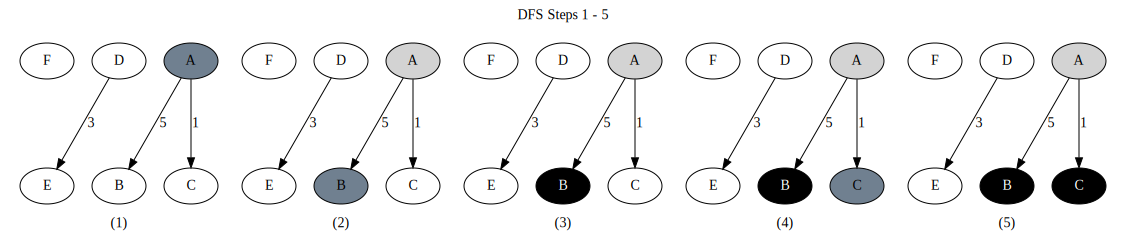

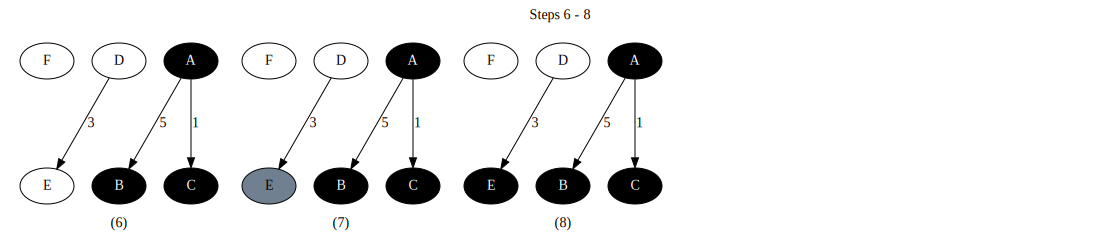

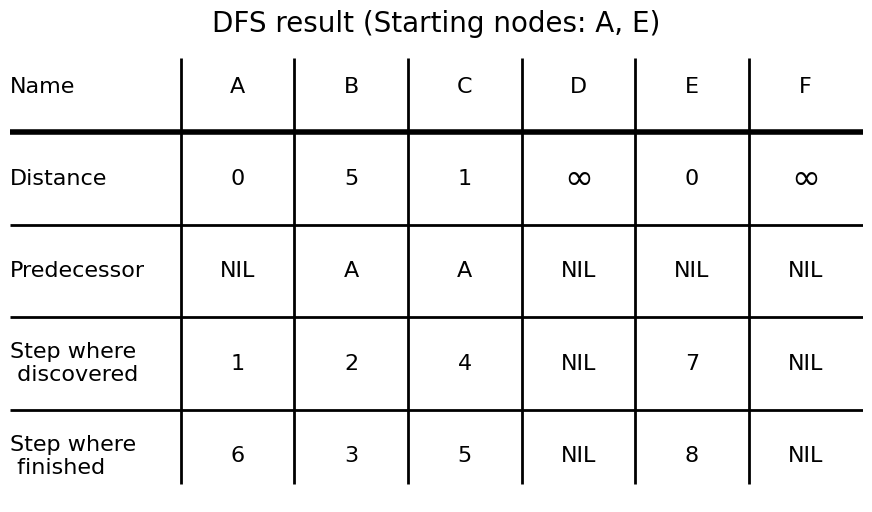

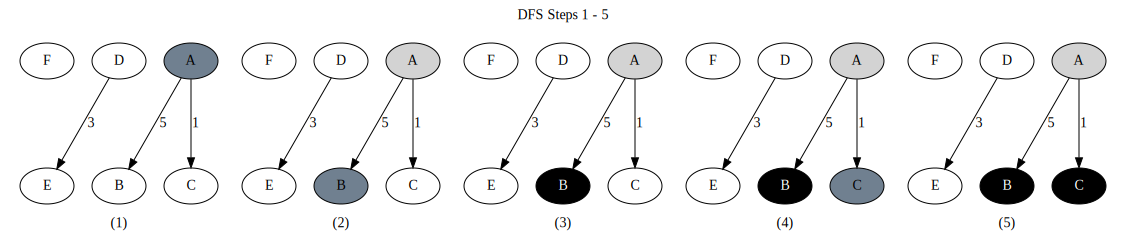

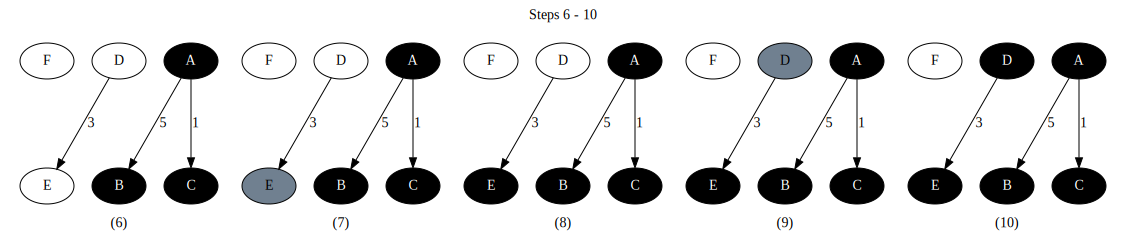

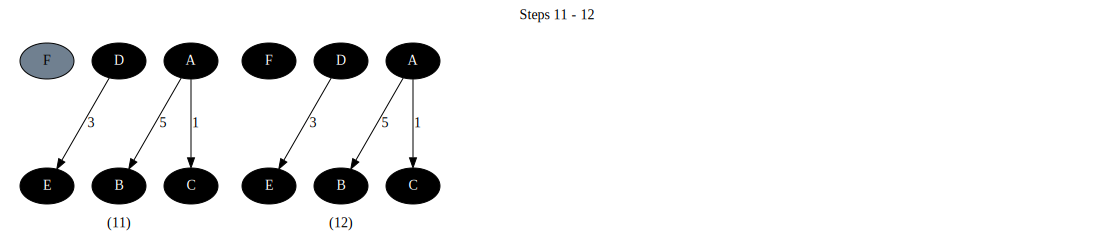

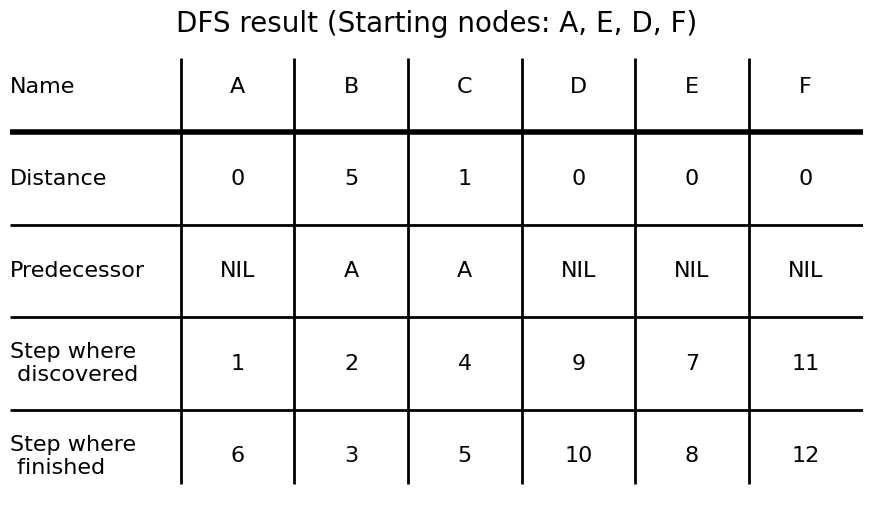

In [16]:
# Input the names of the nodes here
# Nodes will be visited in the order of how they are given in nodearray if multiple options exist

nodearray = ['A', 'B', 'C', 'D', 'E', 'F']

# It is a list (array) of 3-tuples. left and middle components are strings refering to the node names. 
# Left is the start of an edge and the middle is the destination. The rightmost value is the weight of said edge.
# Syntax: edgearray = [('START', 'DESTINATION', WEIGHT), ('STARTx', 'DESTINATIONy', WEIGHTz), ...]
# If you want an unweighted graph, replace the above boolean True with a False.
# In that case you can use any random weights and they will be turned to 1 automatically,
# meaning edgearray = [('A', 'B', 12), ('B', 'C', 151)] will be turned to [('A', 'B', 1), ('B', 'C', 1)]
# Alternatively you can just leave out the weight altogether. Doing this will result in weight 1 regardless of whether its a weighted graph or not
# edgearray = [('A', 'B'), ('B', 'C')] is the same as [('A', 'B', 1), ('B', 'C', 1)]

edgearray = [('A', 'B', 5), ('A', 'C'), ('D', 'E', 3)]

create_graph(nodearray, edgearray)

# The function call has following syntax: "DFS([start0, start1, ...startn], discover-all-nodes?)" (same for BFS)
# The left argument is a list (array) of starting nodes. The algorithm will run with these starting nodes from left to right. Redundant starting nodes are ignored.
# For instance, if your starting nodes were ['A', 'B'] but 'B' was already visited when starting from 'A', then 'B' will just be ignored.
# The chart with results at the end will tell you which starting nodes where not redundant.
# Now for the right argument: It is a boolean with values 'True' and 'False'.
# The 'False' version just goes through the starting nodes (except for the redundant ones)
# The 'True' version will do the same but follow up by calling the algorithm for the unvisited nodes, so that all nodes in the graph are discovered in the end
DFS(['A', 'E', 'B'], False)
# Both calls are identical up until Step 8, then the second version will also visit the remaining nodes whereas the first one does not
DFS(['A', 'E', 'B'], True)
reset_graph()

## Graph type and graphical output options for yet another example graph

In [17]:
# See above for explanations
WEIGHTED_GRAPH = True
DIRECTED_GRAPH = True
BFS_DISPLAY_STEP_BY_STEP = False
GRAPHS_PER_LINE = 5

## Yet another example

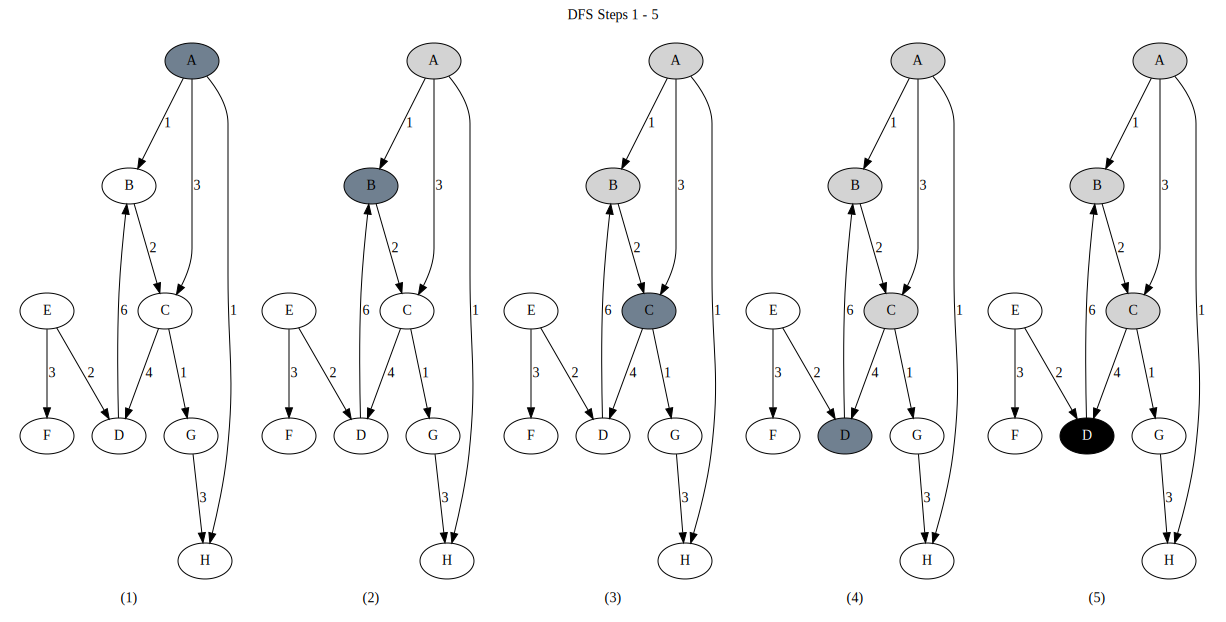

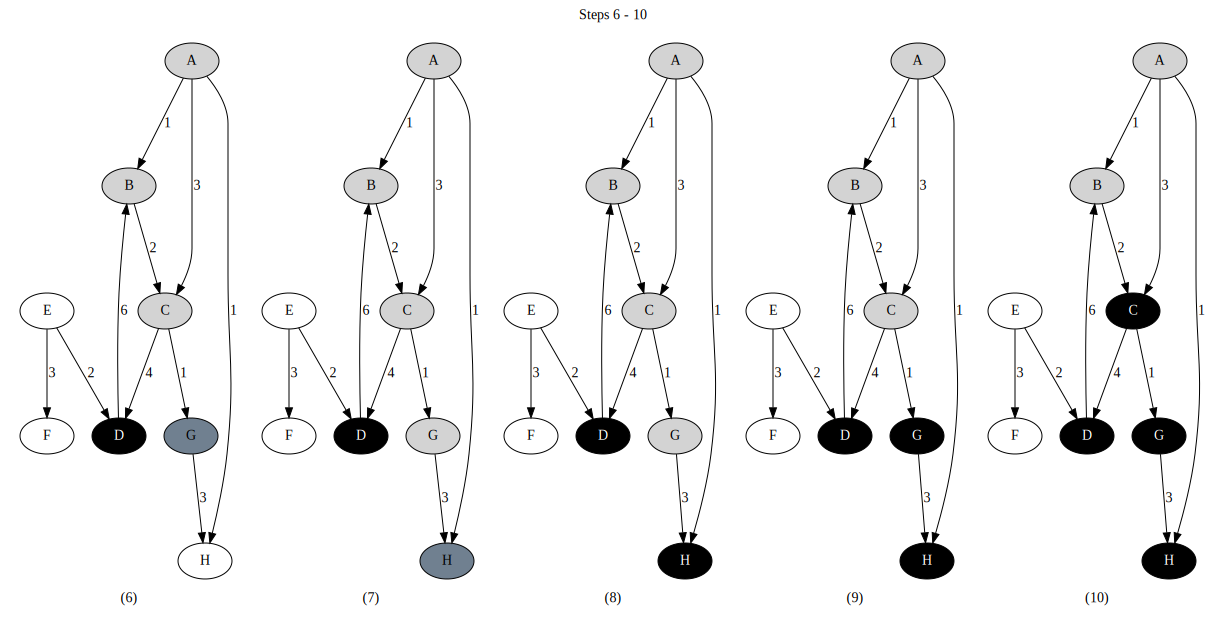

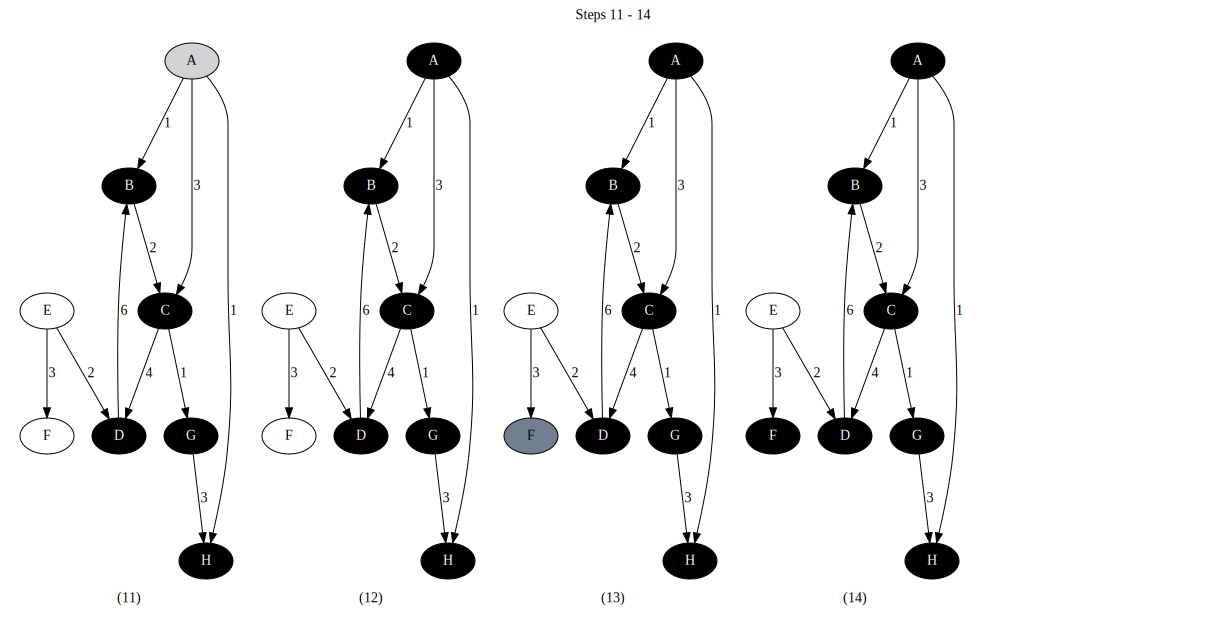

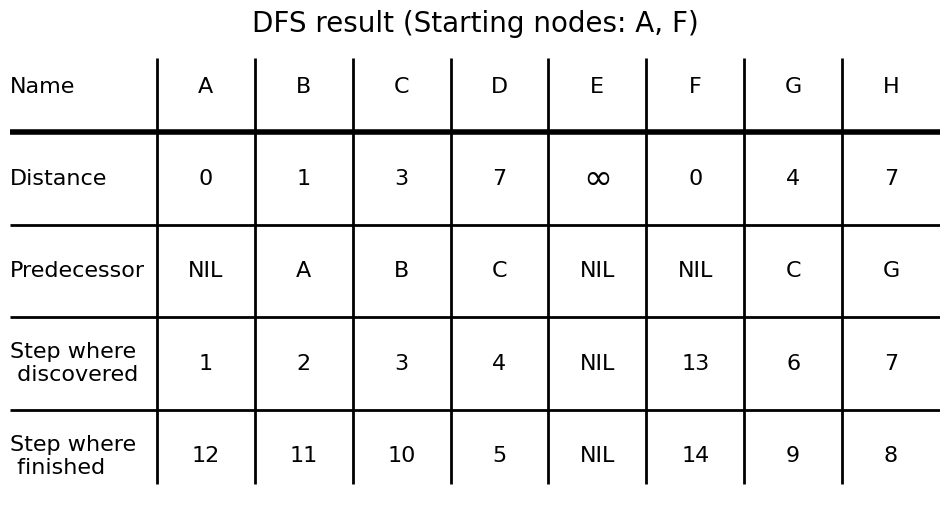

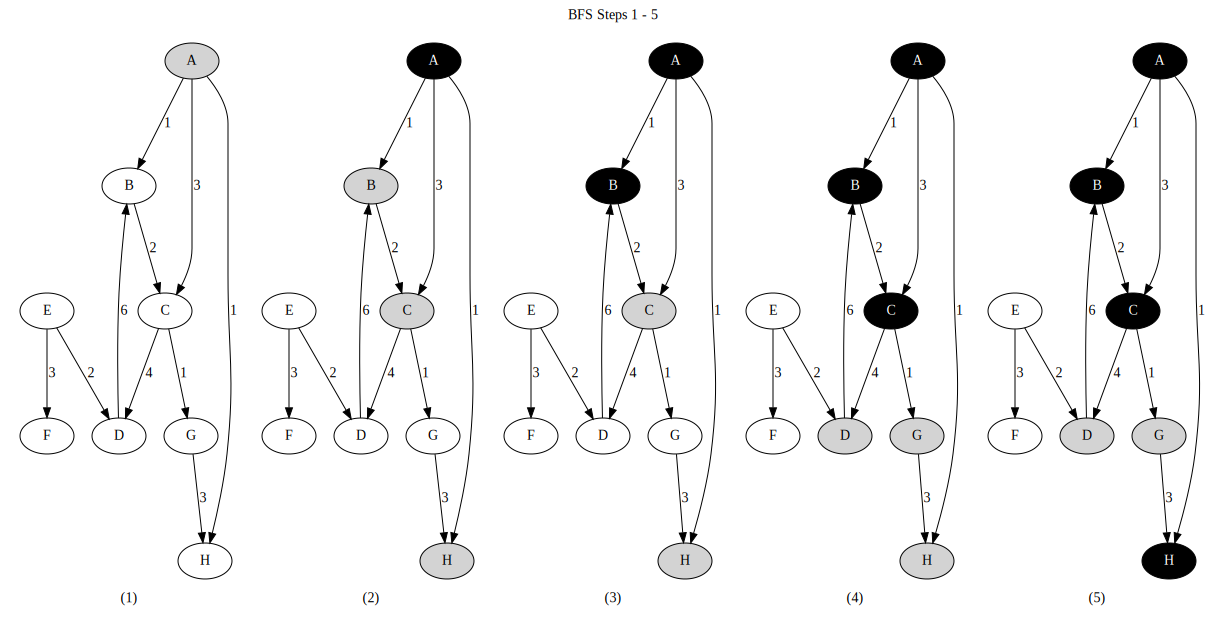

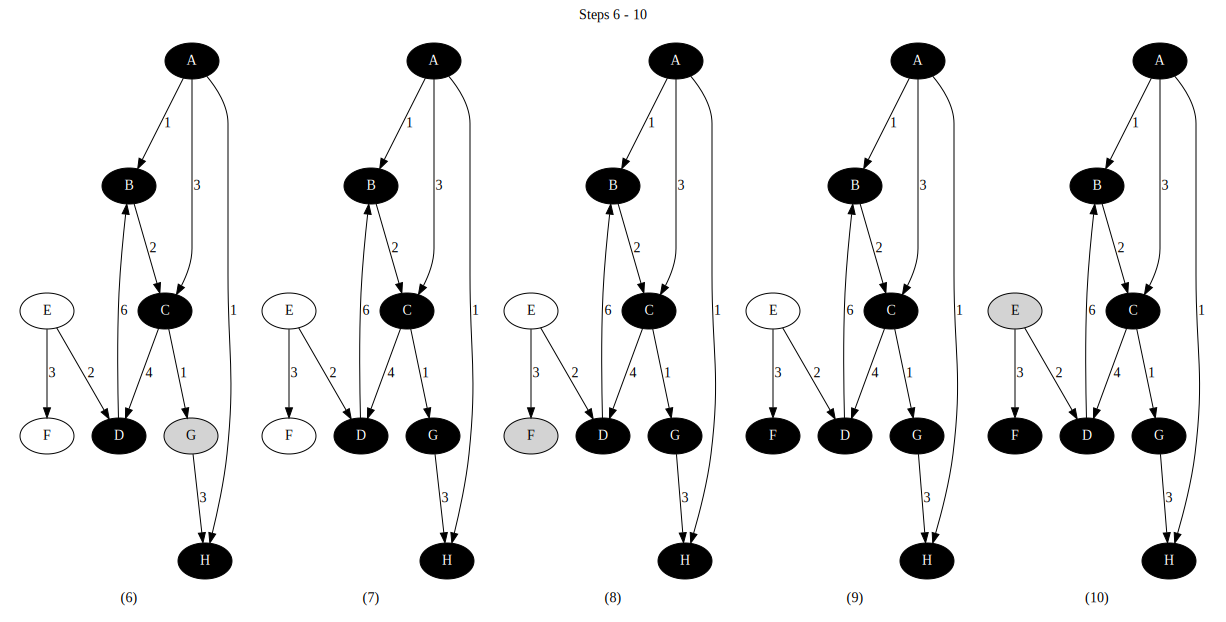

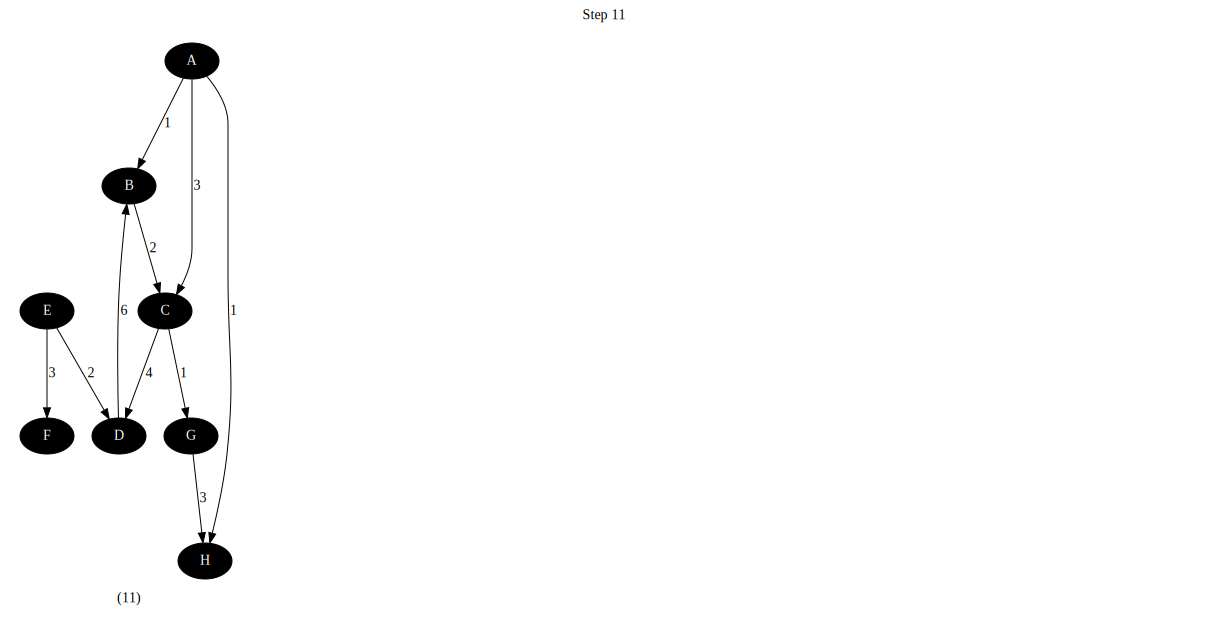

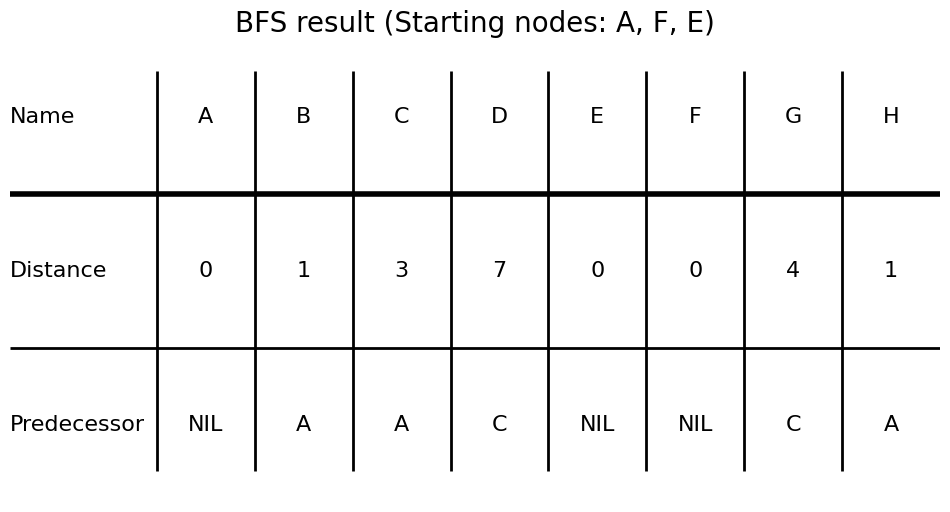

In [18]:
nodearray = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
edgearray = [('A', 'B', 1), ('A', 'C', 3), ('B', 'C', 2), ('D', 'B', 6), ('C', 'D', 4), ('E', 'D', 2), ('E', 'F', 3), ('C', 'G', 1), ('A', 'H', 1), ('G', 'H', 3)]
create_graph(nodearray, edgearray)

DFS(['A', 'F', 'B'], False)
BFS(['A'], True)
reset_graph()

## Select graph type and graphical output options here

In [19]:
# See above for explanations
WEIGHTED_GRAPH = True
DIRECTED_GRAPH = True
BFS_DISPLAY_STEP_BY_STEP = True
GRAPHS_PER_LINE = 5

## Your tests go here...

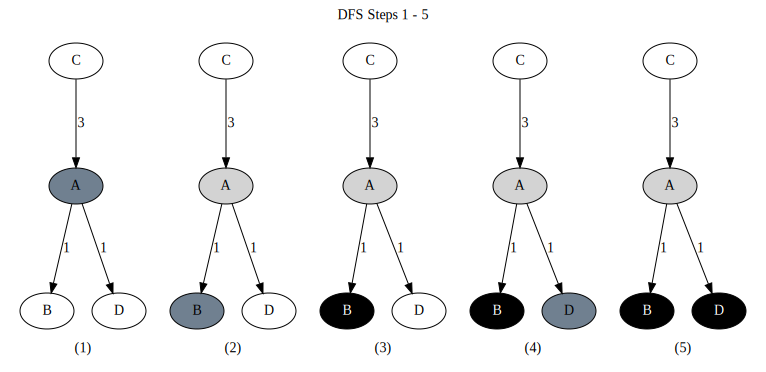

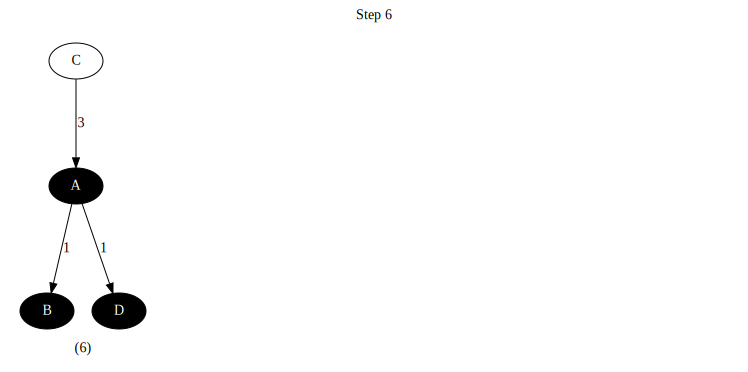

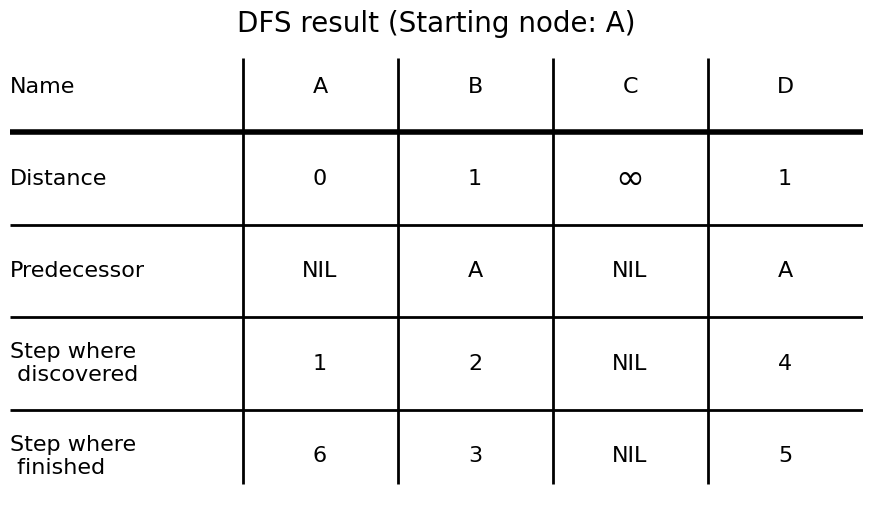

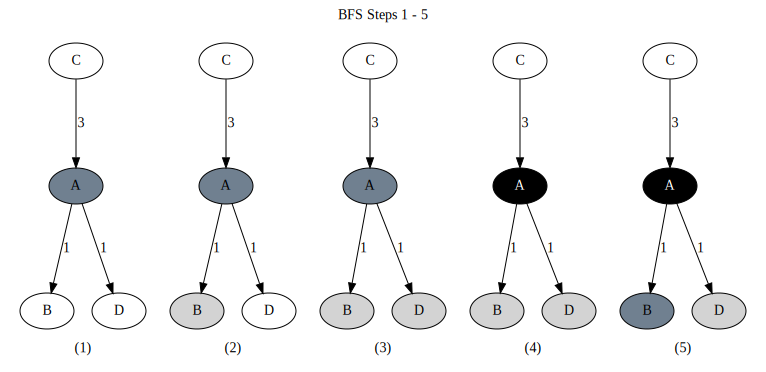

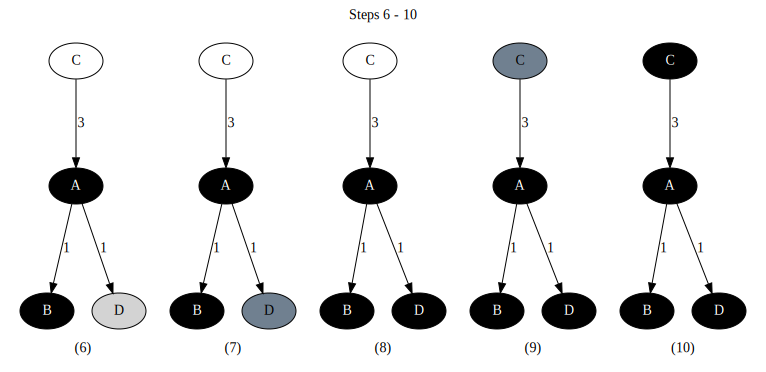

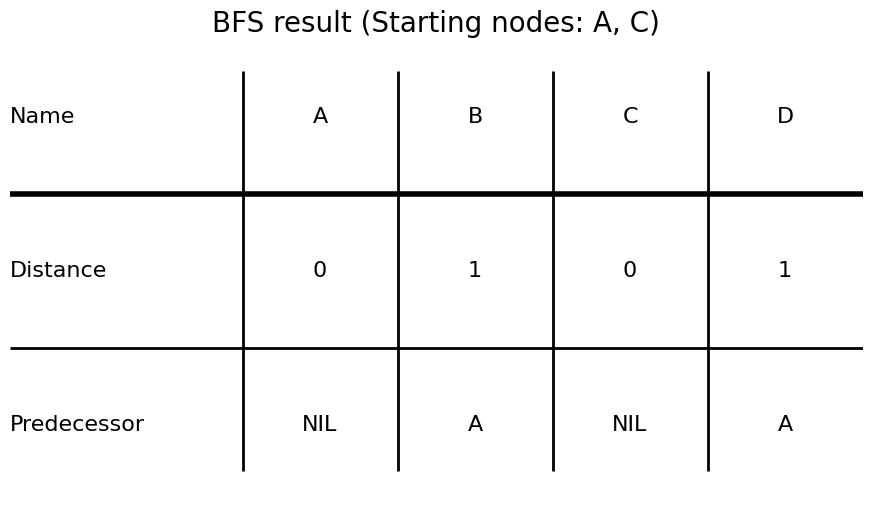

In [20]:
nodearray = ['A', 'B', 'C', 'D']
edgearray = [('A', 'B', 1), ('C', 'A', 3), ('A', 'D')]
create_graph(nodearray, edgearray)

DFS(['A'], False)
BFS(['A'], True)
reset_graph()